In [25]:
from classes.Binary_Predictor import Binary_Predictor
from classes.Mean_LERP_Portfolio import Mean_LERP_Portfolio
from classes.Dataset import Dataset
from classes.Price import Price

from datetime import datetime
from ta import add_all_ta_features
import pandas as pd
import requests
import math
import numpy as np
import time
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
import matplotlib.pyplot as plt
from statistics import mean

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn import svm
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde

import warnings
warnings.filterwarnings('ignore')

OUTPUT_PATH = 'output\\20220212\\'

In [2]:
TECHNICAL_COLS = ['volume_adi', 'volume_obv',
       'volume_cmf', 'volume_fi', 'volume_mfi', 'volume_vpt',
       'volume_nvi', 'volume_vwap', 'volatility_atr', 'volatility_bbm',
       'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp',
       'volatility_bbhi', 'volatility_bbli', 'volatility_kcc',
       'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp',
       'volatility_ui', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff',
       'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
       'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
       'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up_indicator',
       'trend_psar_down_indicator', 'trend_stc', 'momentum_rsi',
       'momentum_stoch_rsi', 'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d',
       'momentum_tsi', 'momentum_uo', 'momentum_stoch',
       'momentum_stoch_signal', 'momentum_wr', 'momentum_ao', 'momentum_kama',
       'momentum_roc', 'momentum_ppo', 'momentum_ppo_signal',
       'momentum_ppo_hist', 'others_dr', 'others_dlr', 'others_cr']

In [3]:
def GetCryptoPriceDF(symbol): 
    cols = ['open', 'high', 'low', 'close', 'volume']
    url = 'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol='+symbol+'&market=CNY&apikey='+AV_KEY
    print(url)
    r = requests.get(url)
    data = r.json()
    dic = data['Time Series (Digital Currency Daily)']
    df = pd.DataFrame.from_dict(dic, orient='index')
    df = df[['1a. open (CNY)', '2a. high (CNY)', '3a. low (CNY)', '4a. close (CNY)', '5. volume']]
    df = df.rename(columns={'1a. open (CNY)': 'open', '2a. high (CNY)': 'high', '3a. low (CNY)': 'low', '4a. close (CNY)': 'close', '5. volume':'volume'})
    df.index.name = 'date'
    df = df.sort_index(ascending = True)
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    return df

def SampleDataframe(df, date, no_samples):
    ind = df.index.get_loc(date)
    if ind-no_samples > 0:
        df = df.iloc[ind+1-no_samples:ind+1,:]
        return df
    return None

# sklearn models
def Reverse_Scale(scaler, y, data_width):
    holder = np.zeros((y.shape[0], data_width))
    holder[:,-1] = y
    holder = scaler.inverse_transform(holder)
    return holder[:,-1]

def TrainForDate(sampled_df, test_size, model, param_grid, pca_comps, no_its):
    data = sampled_df.to_numpy()
    features, label = data[:,:-1], data[:,-1]
    scaler = StandardScaler()
    scl_data = scaler.fit_transform(features)
    x, y = scl_data, label

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)

    #fit pca on train, transform test
    pca = PCA(n_components=pca_comps, random_state=42)
    x_train = pca.fit_transform(x_train)
    x_test = pca.transform(x_test)
    
    print('pca variance: ' + str(sum(pca.explained_variance_ratio_)))

    clf = GridSearchCV(model, param_grid, refit=True, scoring='neg_root_mean_squared_error')
    best_model = clf.fit(x_train, y_train) # model.fit(x_train,y_train)
    y_train_pred = best_model.predict(x_train)
    y_test_pred = best_model.predict(x_test)

    accuracy_test = accuracy_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred, average='weighted')
              
    #y_train_pred = best_model.predict(x_train)
    #y_test_pred = best_model.predict(x_test)
    #y_test_pred_oscale = Reverse_Scale(scaler, y_test_pred, data.shape[1])
    #y_test_acts_oscale = Reverse_Scale(scaler, y_test, data.shape[1])
    #plt.plot(y_test_pred_oscale, label = "predictions")
    #plt.plot(y_test_acts_oscale, label = "actual")
    #plt.show()
    
    #y_train_pred = best_model.predict(x_train)
    #y_test_pred = best_model.predict(x_test)
    #y_test_pred_oscale = Reverse_Scale(scaler, y_test_pred, data.shape[1])
    #y_test_acts_oscale = Reverse_Scale(scaler, y_test, data.shape[1])
    #best_mse_oscale = mean_squared_error(y_test_acts_oscale, y_test_pred_oscale, squared=False)
    
    print('Params: ' + str(best_model.best_params_))
    PlotPredVsAct(y_test_pred, y_test, 'acc: ' + str(accuracy_test) + ', f1: ' + str(f1_test))
    
    return scaler, pca, best_model, f1_test
    
def PlotPredVsAct(pred, acts, title):
    plt.figure(figsize=(7, 2))
    plt.plot(pred, label = "predictions")
    plt.plot(acts, label = "actual")
    plt.legend(loc="upper left")
    
    plt.title(title)
    plt.show()
    
def PredictForDate(df, prev_price, date, scaler, pca, model):
    sampled_df = SampleDataframe(df, date, 1)
    data = sampled_df.to_numpy()
    x, y = data[:,:-1], data[:,-1]
    x = scaler.transform(x)
    x = pca.transform(x)
    y_pred = model.predict(x)
    return y_pred

def GenerateModelResults_OLD(df, base_prices, model_param_sets, pca_comps, no_its, no_samples, test_size, regression_range):
    model_sets_results = {}
    for key in model_param_sets:
        model_param_set = model_param_sets[key]
        #res_dict = {'date':[], 'open':[], 'close':[], 'prediction':[], 'test_mse':[]}
        res_dict = {'date':[], 'params':[], 'test_F1': [], 'prediction':[]}
        for i in regression_range:
            date = df.index[i]
            prev_date = df.index[i-1]
            open = base_prices.iloc[i]['open']
            close = base_prices.iloc[i]['close']

            sampled_df = SampleDataframe(df, prev_date, no_samples)
            scaler, pca, model, test_F1 = TrainForDate(sampled_df, test_size, model_param_set[0], model_param_set[1], pca_comps, no_its)
            prev_price = base_prices.iloc[i-1,-1]
            pred = PredictForDate(df, prev_price, date, scaler, pca, model)

            res_dict['date'].append(date)
            #res_dict['open'].append(open)
            #res_dict['close'].append(close)
            prediction = -1
            if pred[0] == 1:
                prediction = 1
            res_dict['params'].append(model.best_params)
            res_dict['test_F1'].append(test_F1)
            res_dict['prediction'].append(prediction)
            

        model_sets_results[key] = pd.DataFrame(res_dict)
    return model_sets_results

def GenerateModelResults(df, base_prices, model_param_set, pca_comps, no_its, no_samples, test_size, regression_range):
    res_dict = {'date':[], 'params':[], 'test_F1': [], 'prediction':[]}
    for i in regression_range:
        date = df.index[i]
        prev_date = df.index[i-1]

        sampled_df = SampleDataframe(df, prev_date, no_samples)
        scaler, pca, model, test_F1 = TrainForDate(sampled_df, test_size, model_param_set[0], model_param_set[1], pca_comps, no_its)
        prev_price = base_prices.iloc[i-1,-1]
        pred = PredictForDate(df, prev_price, date, scaler, pca, model)

        res_dict['date'].append(date)
        prediction = -1
        if pred[0] == 1:
            prediction = 1
        res_dict['params'].append(model.best_params_)
        res_dict['test_F1'].append(test_F1)
        res_dict['prediction'].append(prediction)

    return pd.DataFrame(res_dict)

def GeneratePredictorResultsOLD(df, base_prices,predictors,model_sets_results, run_range, rolls=[5,10,20]):
    predictors_results = {}
    for pred_key in predictors:
        res_dict = {'date':[],'open':[], 'close':[], 'high':[], 'low':[], 'agg_prediction':[], 'bet_dir':[], 'exit_price':[], 'act_perc_pal':[]}
        x = 0
        for i in run_range:
            date = df.index[i]
            open = base_prices.iloc[i]['open']
            close = base_prices.iloc[i]['close']
            high = base_prices.iloc[i]['high']
            low = base_prices.iloc[i]['low']

            predictor = predictors[pred_key]
            res_dict['date'].append(date)
            res_dict['open'].append(open)
            res_dict['close'].append(close)
            res_dict['high'].append(high)
            res_dict['low'].append(low)
            agg_pred = predictor.get_agg_prediction(x,model_sets_results)
            res_dict['agg_prediction'].append(agg_pred)
            res_dict['bet_dir'].append(predictor.bet_dir(agg_pred))
            res_dict['exit_price'].append(predictor.exit_at(agg_pred, open, close, high, low))
            res_dict['act_perc_pal'].append(predictor.percent_pal(agg_pred, open, close, high, low))
            x+=1

        metrics = pd.DataFrame(res_dict)
        for roll in rolls:
            metrics[str(roll) + 'D_mean'] = metrics['act_perc_pal'].rolling(roll).mean()
            metrics[str(roll) + 'D_cumprod'] = (1 + metrics['act_perc_pal']).rolling(roll).apply(np.prod, raw=True) - 1
        predictors_results[pred_key] = metrics
    return predictors_results

def GeneratePredictorResults(df, base_prices, predictor, model_results, run_range, norm_price):
    res_dict = {'date':[],'bought_at':[], 'prediction':[], 'sold_at':[], 'perc_pal':[]}
    x = 0
    for i in run_range:
        date = df.index[i]
        open = base_prices.iloc[i]['open']
        close = base_prices.iloc[i]['close']
        high = base_prices.iloc[i]['high']
        low = base_prices.iloc[i]['low']
        if norm_price:
            open = base_prices.iloc[i]['norm_open']
            close = base_prices.iloc[i]['norm_close']
            high = base_prices.iloc[i]['norm_high']
            low = base_prices.iloc[i]['norm_low']

        prediction = predictor.get_prediction(x, model_results)
        res_dict['date'].append(date)
        res_dict['bought_at'].append(open)
        res_dict['prediction'].append(prediction)
        res_dict['sold_at'].append(predictor.exit_at(prediction, open, close, high, low))
        res_dict['perc_pal'].append(predictor.percent_pal(prediction, open, close, high, low))
        x+=1

    return pd.DataFrame(res_dict)

def PlotPredictorResults(PredictorName, PredictorResults):
    fig, axs = plt.subplots(2,2, figsize=(12,6))
    axs[0, 0].set_title('rolling means')
    axs[0, 1].set_title('cumulative prods')
    
    for roll in [5,10,20]:
        mean_data = PredictorResults[str(roll) + 'D_mean'].dropna()
        sns.lineplot(data = PredictorResults, x = 'date', y = str(roll) + 'D_mean' , ax=axs[1,0])
        sns.kdeplot(mean_data,bw=0.25,ax=axs[0,0])

        cump_data = PredictorResults[str(roll) + 'D_cumprod'].dropna()
        sns.lineplot(data = PredictorResults, x = 'date', y = str(roll) + 'D_cumprod' , ax=axs[1,1])
        sns.kdeplot(cump_data,bw=0.25,ax=axs[0,1])
        
        if roll == 20:
            print(PredictorName + ', average 20D mean: ' + str(mean_data.mean()) + ', average 20 cumprod: ' + str(cump_data.mean()))
    plt.show()

#portfolio
def GeneratePortfolioResults(portfolio, symbol_classifier_predictor_results, predictors):
    frames = []
    for symbol in symbol_classifier_predictor_results:
        for classifier in symbol_classifier_predictor_results[symbol]:
            for predictor in symbol_classifier_predictor_results[symbol][classifier]:
                pred_df = symbol_classifier_predictor_results[symbol][classifier][predictor]
                pred_df['symbol'] = symbol
                pred_df['classifier'] = classifier
                pred_df['predictor'] = predictor
                pred_df['exit_method'] = predictors[predictor].exit_method
                frames.append(pred_df)
                
    frames = portfolio.Calc_Predictor_Weights(frames)
    port_df = pd.concat(frames)
    port_df['weighted_pal'] = port_df['perc_pal'] * port_df['weight']
    port_df['amount'] = port_df['weight'] * port_df['prediction']
    port_df = port_df[['date','symbol','classifier','predictor','exit_method','bought_at','prediction','5D_mean_pal_S1','lerp','weight','amount','sold_at','perc_pal','weighted_pal']]
    return port_df

def GeneratePortfolioReturns(portfolio_result, rolls = [3, 5]):
    df = portfolio_result[['date','weight','weighted_pal']]
    df = df.groupby(['date']).sum().reset_index()
    for roll in rolls:
        df[str(roll) + 'D_mean'] = df['weighted_pal'].rolling(roll).mean()
        df[str(roll) + 'D_cumprod'] = (1 + df['weighted_pal']).rolling(roll).apply(np.prod, raw=True) - 1
    return df

def GenerateInstructions(date, portfolio_result):
    df = portfolio_result[(portfolio_result['date'] == date)]
    df = df[['date','symbol','exit_method','bought_at','amount']]
    df = df.groupby(['date','symbol','exit_method','bought_at']).sum().reset_index()
    return df


<h1>Run Parameters</h1>

In [4]:
prices = {'500.PAR': Price('500.PAR'),
          'NDAQ': Price('NDAQ'),
          'DAX': Price('DAX'),
          'AAPL': Price('AAPL'),
          'MSFT': Price('MSFT'),
          'AMZN': Price('AMZN'),
          'FB': Price('FB'),
          'GOOGL': Price('GOOGL'),
          'GOOG': Price('GOOG'),
          'TSLA': Price('TSLA'),
          'NVDA': Price('NVDA')}

datasets = {'500.PAR':Dataset(label='500.PAR', 
                              symbols=['500.PAR','NDAQ','DAX','AAPL','MSFT','AMZN','FB','GOOGL','GOOG'], 
                              pivot_cols = ['open','high','low','close','volume'], 
                              pivots = {1:[1,2,3,4,5,6,7,8,9,10],10:[10,20,30]},
                              technical_cols = ['volume_adi']),
           'NDAQ':Dataset(label='NDAQ', 
                              symbols=['500.PAR','NDAQ','DAX','AAPL','MSFT','AMZN','FB','GOOGL','GOOG'], 
                              pivot_cols = ['open','high','low','close','volume'], 
                              pivots = {1:[1,2,3,4,5,6,7,8,9,10],10:[10,20,30]},
                              technical_cols = ['volume_adi'])}

<h1> Prices </h1>

In [5]:
read_price_data = True

price_data = {}
for p in prices:
    if read_price_data:
        price_data[p] = pd.read_csv(OUTPUT_PATH + 'prices\\' + p + '.csv', index_col = 'date')
    else:
        print('downloading price: ' + p)
        price_data[p] = prices2[p].CreatePriceData()
        price_data[p].to_csv(OUTPUT_PATH + 'prices\\' + p + '.csv', index=True)  

In [6]:
print(price_data['500.PAR'].shape)
print(price_data['500.PAR'].tail())

(3016, 13)
               open     high      low    close  volume  open_1D_diff_perc  \
date                                                                        
2022-02-07  74.3731  74.5863  73.8862  74.1579    7822          -0.002939   
2022-02-08  74.2349  74.5648  73.8901  74.5648   10114          -0.001858   
2022-02-09  74.9191  75.5556  74.9191  75.4897    7360           0.009217   
2022-02-10  75.7833  75.7833  74.8639  74.8639    5834           0.011535   
2022-02-11  74.4168  74.9084  74.1498  74.3300  850950          -0.018032   

            open_1D_diff_perc_20D_STD  target_STD  leverage   norm_open  \
date                                                                      
2022-02-07                   0.010279       0.015  1.459332  108.535053   
2022-02-08                   0.010278       0.015  1.459419  108.339820   
2022-02-09                   0.010356       0.015  1.448476  108.518517   
2022-02-10                   0.010601       0.015  1.414956  107.230000   

<h1>Datasets </h1>

In [7]:
read_dataset_data = True

dataset_results = {}
for ds in datasets:
    if read_dataset_data:
        dataset_results[ds] = pd.read_csv(OUTPUT_PATH + 'datasets\\' + ds + '.csv', index_col = 'date')
    else:
        print('creating dataset for: ' + ds)
        dataset_results[ds] = datasets[ds].CreateDataset(price_data)
        dataset_results[ds].to_csv(OUTPUT_PATH + 'datasets\\' + ds + '.csv', index=True)  
    
for ds in datasets: #make sure base price data is only as long as it's dataset
    price_data[ds] = price_data[ds][price_data[ds].index.isin(dataset_results[ds].index)] 

In [8]:
print(dataset_results['500.PAR'].shape)
print(dataset_results['NDAQ'].shape)

(1827, 604)
(1827, 604)


<h1>Classifiers</h1>
<p>classifiers generate signals for each of the datesets</p>

In [9]:
read_classifier_results = False

#how many dates to run
last_run_date = '2021-10-01'
run_size = 10

#classifier training parameters
pca_comps = 150
no_samples = 400
test_size = 0.33

classifiers = {'M1': (MLPClassifier(random_state=42), {'hidden_layer_sizes':[(56,28),(28,14),(64,32,16)], 'max_iter':[100,200], 'activation':['relu'], 'solver':['adam'], 'learning_rate_init':[0.001,0.01]})}#,
                    #'M2': (SVC(gamma=2),{'C':[0.025,0.25,1]}),
                    #'M3': (DecisionTreeClassifier(),{'max_depth':[5,10]}),
                    #'M4': (RandomForestClassifier(),{'max_depth':[5,10], 'n_estimators':[5,10],'max_features':[1]})}

training: M1 for dataset: 500.PAR
pca variance: 0.9705382998136731
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


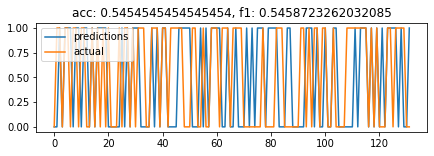

pca variance: 0.9701521597847467
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


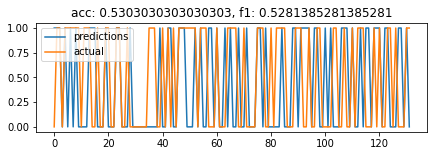

pca variance: 0.9705681736959957
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


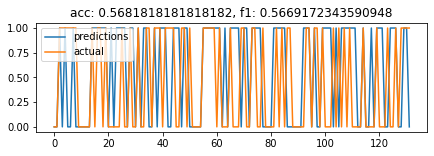

pca variance: 0.9704683945646284
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


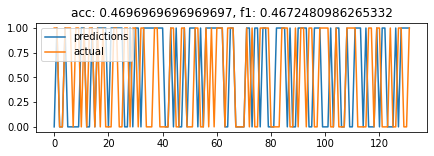

pca variance: 0.9699736135198589
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


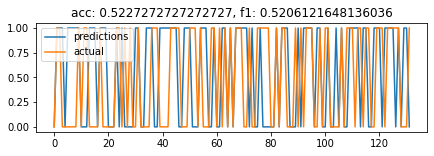

pca variance: 0.9703770421748259
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


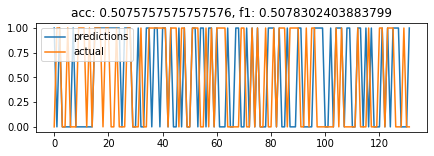

pca variance: 0.97042237240895
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


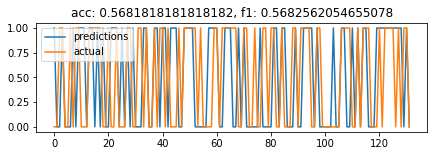

pca variance: 0.9699846245201523
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


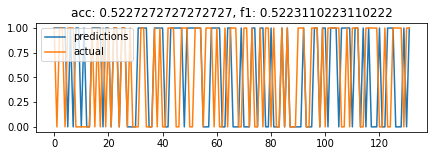

pca variance: 0.9697131223489149
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


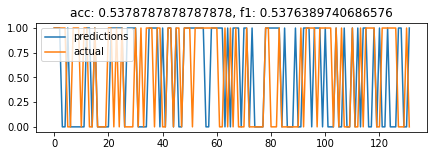

pca variance: 0.9699585572212487
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


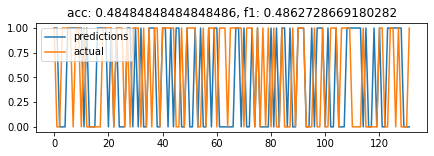

training: M1 for dataset: NDAQ
pca variance: 0.9705382998136731
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


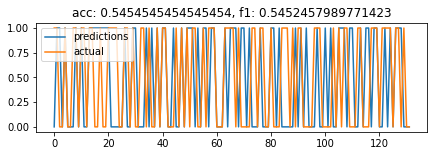

pca variance: 0.9701521597847467
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


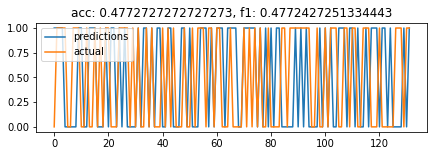

pca variance: 0.9705681736959957
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


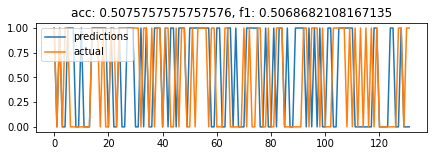

pca variance: 0.9704683945646284
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


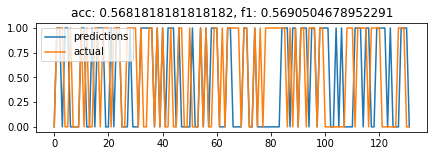

pca variance: 0.9699736135198589
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


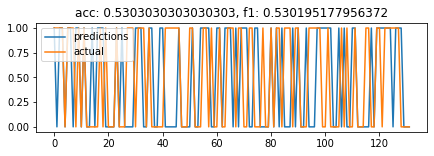

pca variance: 0.9703770421748259
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


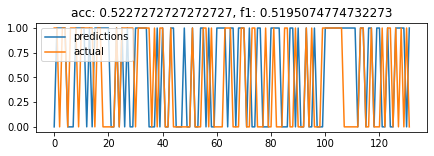

pca variance: 0.97042237240895
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


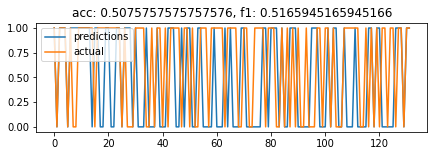

pca variance: 0.9699846245201523
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


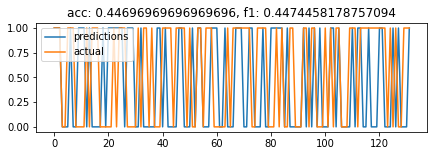

pca variance: 0.9697131223489149
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


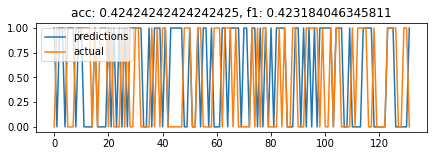

pca variance: 0.9699585572212487
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


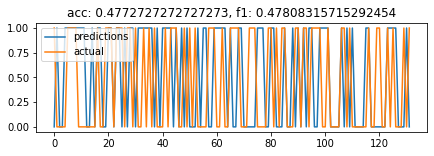

In [10]:
dataset_classifier_results = {}
for dataset in datasets: 
    classifier_results = {}
    df = dataset_results[dataset]
    base_prices = price_data[datasets[dataset].label]
    test_ind = df.index.get_loc(last_run_date)
    run_range = range(test_ind-run_size, test_ind)  
    for classifier_key in classifiers:
        if read_classifier_results:
            classifier_results[classifier_key] = pd.read_csv(OUTPUT_PATH + 'classifiers\\' + dataset + '_' + classifier_key + '.csv')
        else:
            print('training: ' + classifier_key + ' for dataset: ' + dataset)
            classifier = classifiers[classifier_key] 
            classifier_results[classifier_key] = GenerateModelResults(df, base_prices, classifier, pca_comps, 1, no_samples, test_size, run_range) 
            
            classifier_results[classifier_key].to_csv(OUTPUT_PATH + 'classifiers\\' + dataset + '_' + classifier_key + '.csv', index=False)
    
    dataset_classifier_results[dataset] = classifier_results

In [11]:
dataset_classifier_results['500.PAR']['M1']

,date,params,test_F1,prediction
0,2021-09-17,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.545872,-1
1,2021-09-20,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.528139,1
2,2021-09-21,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.566917,1
3,2021-09-22,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.467248,1
4,2021-09-23,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.520612,1
5,2021-09-24,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.507830,-1
6,2021-09-27,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.568256,-1
7,2021-09-28,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.522311,-1
8,2021-09-29,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.537639,1
9,2021-09-30,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.486273,1


In [12]:
dataset_classifier_results['NDAQ']['M1']

,date,params,test_F1,prediction
0,2021-09-17,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.545246,-1
1,2021-09-20,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.477243,-1
2,2021-09-21,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.506868,-1
3,2021-09-22,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.569050,-1
4,2021-09-23,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.530195,-1
5,2021-09-24,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.519507,-1
6,2021-09-27,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.516595,1
7,2021-09-28,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.447446,1
8,2021-09-29,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.423184,1
9,2021-09-30,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.478083,1


<h1>Trader</h1>
<p>Every trader definition is generated for every classifier. They convert classifier signals to a normalised daily return using sell-off rules</p>

In [13]:
read_trader_results = False

norm_price = True
predictors = {'P1': Binary_Predictor(threshold=0.005, exit_method='at_close', models=['M1'], pred_method='ave'),
             'P2': Binary_Predictor(threshold=0.005, exit_method='capture_gains', models=['M1'], pred_method='ave', capture_thresh = 0.01)}

In [14]:
dataset_classifier_predictor_results = {}
for dataset in datasets:    
    test_ind = df.index.get_loc(last_run_date)
    run_range = range(test_ind-run_size, test_ind)  
    df  = dataset_results[dataset]
    base_prices = price_data[datasets[dataset].label]
    classifier_predictor_results = {}
    for classifier_key in classifiers:
        classifier_results = dataset_classifier_results[dataset][classifier_key]
        predictor_results = {}
        for predictor_key in predictors:
            if read_trader_results:
                predictor_results[predictor_key] = pd.read_csv(OUTPUT_PATH + 'traders\\' + dataset + '_' + classifier_key + '_' + predictor_key + '.csv')
            else:
                print('calculating trader: ' + predictor_key + ', for classifier: ' + classifier_key + ', dataset: ' + dataset)
                predictor_results[predictor_key] = GeneratePredictorResults(df, base_prices, predictors[predictor_key], classifier_results, run_range, norm_price)
                predictor_results[predictor_key].to_csv(OUTPUT_PATH + 'traders\\' + dataset + '_' + classifier_key + '_' + predictor_key + '.csv', index=False)
    
        classifier_predictor_results[classifier_key] = predictor_results
    dataset_classifier_predictor_results[dataset] = classifier_predictor_results

calculating trader: P1, for classifier: M1, dataset: 500.PAR
calculating trader: P2, for classifier: M1, dataset: 500.PAR
calculating trader: P1, for classifier: M1, dataset: NDAQ
calculating trader: P2, for classifier: M1, dataset: NDAQ


In [15]:
dataset_classifier_predictor_results['500.PAR']['M1']['P1']

,date,bought_at,prediction,sold_at,perc_pal
0,2021-09-17,237.532200,-1,235.150054,0.010029
1,2021-09-20,181.256178,1,179.706564,-0.008549
2,2021-09-21,187.082689,1,186.850329,-0.001242
3,2021-09-22,187.081720,1,187.911897,0.004438
4,2021-09-23,177.190230,1,178.516219,0.007483
5,2021-09-24,175.527845,-1,176.083829,-0.003167
6,2021-09-27,164.967801,-1,164.043256,0.005604
7,2021-09-28,160.462322,-1,157.901364,0.015960
8,2021-09-29,146.814832,1,147.702730,0.006048
9,2021-09-30,139.909990,1,138.742009,-0.008348


In [16]:
dataset_classifier_predictor_results['500.PAR']['M1']['P2']

,date,bought_at,prediction,sold_at,perc_pal
0,2021-09-17,237.532200,-1,235.156878,0.010000
1,2021-09-20,181.256178,1,179.706564,-0.008549
2,2021-09-21,187.082689,1,186.850329,-0.001242
3,2021-09-22,187.081720,1,187.911897,0.004438
4,2021-09-23,177.190230,1,178.516219,0.007483
5,2021-09-24,175.527845,-1,176.083829,-0.003167
6,2021-09-27,164.967801,-1,164.043256,0.005604
7,2021-09-28,160.462322,-1,158.857698,0.010000
8,2021-09-29,146.814832,1,147.702730,0.006048
9,2021-09-30,139.909990,1,138.742009,-0.008348


In [17]:
dataset_classifier_predictor_results['NDAQ']['M1']['P1']

,date,bought_at,prediction,sold_at,perc_pal
0,2021-09-17,313.299839,-1,310.148512,0.010059
1,2021-09-20,274.719339,-1,276.616752,-0.006907
2,2021-09-21,266.771055,-1,265.994832,0.002910
3,2021-09-22,272.813038,-1,273.897361,-0.003975
4,2021-09-23,272.080706,-1,272.303472,-0.000819
5,2021-09-24,270.577928,-1,273.173899,-0.009594
6,2021-09-27,269.617443,1,268.438278,-0.004373
7,2021-09-28,267.224856,1,263.268113,-0.014807
8,2021-09-29,259.705232,1,262.492669,0.010733
9,2021-09-30,254.330475,1,251.619007,-0.010661


In [18]:
dataset_classifier_predictor_results['NDAQ']['M1']['P2']

,date,bought_at,prediction,sold_at,perc_pal
0,2021-09-17,313.299839,-1,310.166841,0.010000
1,2021-09-20,274.719339,-1,276.616752,-0.006907
2,2021-09-21,266.771055,-1,265.994832,0.002910
3,2021-09-22,272.813038,-1,273.897361,-0.003975
4,2021-09-23,272.080706,-1,272.303472,-0.000819
5,2021-09-24,270.577928,-1,273.173899,-0.009594
6,2021-09-27,269.617443,1,268.438278,-0.004373
7,2021-09-28,267.224856,1,263.268113,-0.014807
8,2021-09-29,259.705232,1,262.302284,0.010000
9,2021-09-30,254.330475,1,256.873779,0.010000


<h1>Allocators</h1>
<p>Allocators take all the traders and score them then allocate to them based on previous days score</p>

In [19]:
read_allocator_results = False

allocators = {'P1': Mean_LERP_Portfolio(mean_periods = 5, min_lerp = 0.25, max_lerp = 1)}

In [20]:
allocator_results, allocator_returns = {}, {}
for pk in allocators:
    if read_allocator_results:
        allocator_results[pk] = pd.read_csv(OUTPUT_PATH + 'allocators\\' + pk + '.csv')
    else:
        allocator_results[pk] = GeneratePortfolioResults(allocators[pk], dataset_classifier_predictor_results, predictors)
        allocator_results[pk].to_csv(OUTPUT_PATH + 'allocators\\'  + pk + '.csv', index=False)
    
    allocator_returns[pk] = GeneratePortfolioReturns(allocator_results[pk])

In [21]:
allocator_results['P1'][(allocator_results['P1']['date']=='2021-09-24')]

,date,symbol,classifier,predictor,exit_method,bought_at,prediction,5D_mean_pal_S1,lerp,weight,amount,sold_at,perc_pal,weighted_pal
5,2021-09-24,500.PAR,M1,P1,at_close,175.527845,-1,0.002432,1.000000,0.399674,-0.399674,176.083829,-0.003167,-0.001266
5,2021-09-24,500.PAR,M1,P2,capture_gains,175.527845,-1,0.002426,0.998032,0.398887,-0.398887,176.083829,-0.003167,-0.001263
5,2021-09-24,NDAQ,M1,P1,at_close,270.577928,-1,0.000254,0.254008,0.101520,-0.101520,273.173899,-0.009594,-0.000974
5,2021-09-24,NDAQ,M1,P2,capture_gains,270.577928,-1,0.000242,0.250000,0.099918,-0.099918,273.173899,-0.009594,-0.000959


In [22]:
allocator_returns['P1']

,date,weight,weighted_pal,3D_mean,3D_cumprod,5D_mean,5D_cumprod
0,2021-09-17,0.0,0.000000,NaN,NaN,NaN,NaN
1,2021-09-20,0.0,0.000000,NaN,NaN,NaN,NaN
2,2021-09-21,0.0,0.000000,0.000000,0.000000,NaN,NaN
3,2021-09-22,0.0,0.000000,0.000000,0.000000,NaN,NaN
4,2021-09-23,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
5,2021-09-24,1.0,-0.004462,-0.001487,-0.004462,-0.000892,-0.004462
6,2021-09-27,1.0,0.003609,-0.000284,-0.000869,-0.000171,-0.000869
7,2021-09-28,1.0,0.007423,0.002190,0.006547,0.001314,0.006547
8,2021-09-29,1.0,0.006936,0.005989,0.018071,0.002701,0.013529
9,2021-09-30,1.0,-0.006704,0.002552,0.007609,0.001360,0.006733


In [23]:
GenerateInstructions('2021-09-24', allocator_results['P1'])

,date,symbol,exit_method,bought_at,amount
0,2021-09-24,500.PAR,at_close,175.527845,-0.399674
1,2021-09-24,500.PAR,capture_gains,175.527845,-0.398887
2,2021-09-24,NDAQ,at_close,270.577928,-0.101520
3,2021-09-24,NDAQ,capture_gains,270.577928,-0.099918
